In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization,Flatten,Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import GridSearchCV, cross_val_score
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold

In [ ]:
!unzip "/content/drive/MyDrive/Dataset - Plant-seedlings-classification.zip" #unziping the dataset folder

Streaming output truncated to the last 5000 lines.
  inflating: test/ad12382d4.png      
  inflating: test/adb7a032c.png      
  inflating: test/ae90f2827.png      
  inflating: test/aecfaed64.png      
  inflating: test/aee6fa3df.png      
  inflating: test/af45e222a.png      
  inflating: test/afa446484.png      
  inflating: test/afcf6abd5.png      
  inflating: test/b026bf8ca.png      
  inflating: test/b03397525.png      
  inflating: test/b0acaff4a.png      
  inflating: test/b130a0632.png      
  inflating: test/b145ba9d4.png      
  inflating: test/b1cd2a91e.png      
  inflating: test/b215531dd.png      
  inflating: test/b2706e2b3.png      
  inflating: test/b29339405.png      
  inflating: test/b30ab4659.png      
  inflating: test/b31292706.png      
  inflating: test/b341d0aab.png      
  inflating: test/b39c71707.png      
  inflating: test/b3d6fdb80.png      
  inflating: test/b3e08b037.png      
  inflating: test/b47691c08.png      
  inflating: test/b4c3df835.png      

###Preparing Training and Validation data

In [ ]:
img_len= 160 
img_breath = 160
batch_size = 32

In [ ]:
train_dir = '/content/train'
test_dir = '/content/test'

In [ ]:
os.chdir(train_dir)

In [ ]:
os.listdir()

['Cleavers',
 'Common Chickweed',
 'Charlock',
 'Maize',
 'Black-grass',
 'Fat Hen',
 'Common wheat',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Scentless Mayweed',
 'Loose Silky-bent',
 'Sugar beet']

Loading Images from the directory

In [ ]:
x_train = []
y_train = []

In [ ]:
for i in os.listdir():
  print(i)
  for j in os.listdir(i):
    img = cv2.imread(train_dir+'/'+i+'/'+j) ## reading the images in each folders
    res = cv2.resize(img,(160,160)) ##  resizing the images into 160*160 pixels.
    x_train.append(res)
    y_train.append(i)

Cleavers
Common Chickweed
Charlock
Maize
Black-grass
Fat Hen
Common wheat
Shepherds Purse
Small-flowered Cranesbill
Scentless Mayweed
Loose Silky-bent
Sugar beet


In [ ]:
X_train = np.array(x_train)

In [ ]:
X_train.shape

(4750, 160, 160, 3)

In [ ]:
Y_train = pd.DataFrame(y_train)

In [ ]:
Y_train.sample(5)

,0
1530,Black-grass
844,Common Chickweed
4191,Loose Silky-bent
4073,Loose Silky-bent
527,Common Chickweed


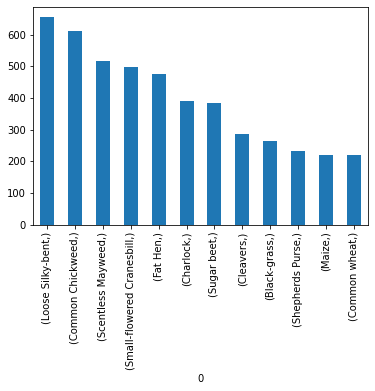

In [ ]:
Y_train.value_counts().plot(kind='bar')

Label: Cleavers


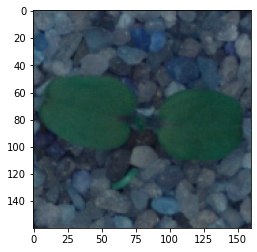

In [ ]:
plt.imshow(X_train[155])
print("Label: {}".format(y_train[155]))

Encoding the target feature

In [ ]:
from sklearn.preprocessing import LabelEncoder
LE= LabelEncoder()
Y = LE.fit_transform(Y_train[0])

In [ ]:
np.unique(Y)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [ ]:
from sklearn.model_selection import train_test_split
xtrain, xval, y_train, y_val = train_test_split(X_train, Y, test_size = 0.2, random_state= 123)

In [ ]:
print(xtrain.shape, xval.shape, y_train.shape, y_val.shape)

(3800, 160, 160, 3) (950, 160, 160, 3) (3800,) (950,)


Converting the target into categorical(one-hot encoding the class vector)

In [ ]:
from tensorflow.keras.utils import to_categorical
ytrain = to_categorical(y_train, num_classes=12)
yval= to_categorical(y_val, num_classes=12)

In [ ]:
print(yval)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


Normalizing the data for Neural network model

In [ ]:
xtrain_n = (xtrain/255).astype('float32')
xval_n = (xval/255).astype('float32')
#xtest_n = (xtest/255).astype('float32')

In [ ]:
print(xtrain_n.shape, xval_n.shape,ytrain.shape, yval.shape)

(3800, 160, 160, 3) (950, 160, 160, 3) (3800, 12) (950, 12)


#Building Neural Network

In [ ]:
plant_NN = Sequential()

In [ ]:
plant_NN.add(Flatten())
plant_NN.add(Dense(512,activation = 'relu'))
plant_NN.add(BatchNormalization())
plant_NN.add(Dense(256,activation = 'relu'))
plant_NN.add(BatchNormalization())
plant_NN.add(Dense(128,activation = 'relu'))
plant_NN.add(BatchNormalization())
plant_NN.add(Dropout(0.2))
plant_NN.add(Dense(64,activation = 'relu'))
plant_NN.add(BatchNormalization())
plant_NN.add(Dropout(0.15))
plant_NN.add(Dense(32,activation = 'relu'))
plant_NN.add(Dropout(0.15))
plant_NN.add(Dense(12,activation = 'softmax'))

In [ ]:
batch_size = 32
epochs = 15

plant_NN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#Saving the best model using model checkpoint callback
checkpoint= ModelCheckpoint('/content/plant_seedlings.h5',save_best_only=True, monitor='val_accuracy', 
                                                    mode='max', verbose=1)

In [ ]:
history= plant_NN.fit(xtrain_n, ytrain, batch_size=batch_size,epochs= epochs, validation_data = (xval_n, yval),
                      callbacks=[checkpoint],verbose=1)

Epoch 1/15
119/119 [==============================] - 5s 29ms/step - loss: 2.6032 - accuracy: 0.1509 - val_loss: 3.2228 - val_accuracy: 0.1442

Epoch 00001: val_accuracy improved from -inf to 0.14421, saving model to /content/plant_seedlings.h5
Epoch 2/15
119/119 [==============================] - 3s 27ms/step - loss: 2.1233 - accuracy: 0.2710 - val_loss: 2.4190 - val_accuracy: 0.1979

Epoch 00002: val_accuracy improved from 0.14421 to 0.19789, saving model to /content/plant_seedlings.h5
Epoch 3/15
119/119 [==============================] - 3s 26ms/step - loss: 1.8483 - accuracy: 0.3541 - val_loss: 1.9724 - val_accuracy: 0.3295

Epoch 00003: val_accuracy improved from 0.19789 to 0.32947, saving model to /content/plant_seedlings.h5
Epoch 4/15
119/119 [==============================] - 3s 26ms/step - loss: 1.6080 - accuracy: 0.4483 - val_loss: 2.1656 - val_accuracy: 0.2895

Epoch 00004: val_accuracy did not improve from 0.32947
Epoch 5/15
119/119 [==============================] - 3s 27m

#CNN Model

Function to normalize image according to Model being used

In [ ]:
def normalize(img):
    
    #Normalize for ResNet50
    return tf.keras.applications.resnet50.preprocess_input(img) ## this will normalize the data according to Restnet model.

####Building train, validation generators and resizing images

Train and Validation Features

Augmentation - Defining ImageDataGenerator for both Training and validation Separately

In [ ]:
train_aug = ImageDataGenerator(rotation_range= 30, width_shift_range = 0.2,shear_range=0.2, zoom_range=0.3,
                                     height_shift_range = 0.2, horizontal_flip = True, 
                                     preprocessing_function=normalize)
                                      ## Training set with augmentation along with processing function

In [ ]:
val_aug = ImageDataGenerator(preprocessing_function=normalize) ## validation set without augmentation

In [ ]:
test_aug = ImageDataGenerator(preprocessing_function=normalize) ## test set without augmentation

Fitting the Augment Generator

In [ ]:
train_generator = train_aug.flow(xtrain,ytrain,batch_size=64)
val_generator = val_aug.flow(xval,yval,batch_size=64)

Generating 5 augmented images of 1 image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


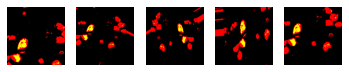

In [ ]:
gen = train_aug.flow(xtrain[15:16], batch_size=1)
for i in range(1, 6):
    plt.subplot(1,5,i)
    plt.axis("off")
    plt.imshow(gen.next().squeeze())
    plt.plot()
plt.show()

#Loading the pre-trained Restnet50 model

In [ ]:
model = tf.keras.applications.ResNet50(include_top=False, 
                                       input_shape=(160,160,3),
                                       weights='imagenet')

94773248/94765736 [==============================] - 2s 0us/step


In [ ]:
model.output

<KerasTensor: shape=(None, 5, 5, 2048) dtype=float32 (created by layer 'conv5_block3_out')>

In [ ]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 166, 166, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 80, 80, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 80, 80, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

Freezing the layers of pre-trained restnet model

In [ ]:
len(model.layers)

175

In [ ]:
for layer in model.layers:  ## will make the pre-trained layer not trainable.
    layer.trainable = False

model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 166, 166, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 80, 80, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 80, 80, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

Adding Fully connected layer

In [ ]:
out = model.output #output of pre-trained model
Pool_layer = GlobalAveragePooling2D()(out)
Pool_layer ## number of weights reduced from (5*5*2048) to (2048)

<KerasTensor: shape=(None, 2048) dtype=float32 (created by layer 'global_average_pooling2d')>

In [ ]:
#Adding output layer
last_layer = Dense(12,activation = 'softmax')(Pool_layer)

Building the final model

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
rest_model = tf.keras.models.Model(inputs = model.input,  #input of Inception model
                                   outputs = last_layer) #output layer

In [ ]:
rest_model.compile(optimizer = 'adam', loss= 'categorical_crossentropy',metrics=['accuracy'])

In [ ]:
rest_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 166, 166, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 80, 80, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 80, 80, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

Model Training

In [ ]:
#Saving the best model using model checkpoint callback
checkpoint= ModelCheckpoint('/content/plant_seedlings.h5',save_best_only=True, monitor='val_accuracy', 
                                                    mode='max', verbose=1)

In [ ]:
rest_model.fit(train_generator, epochs = 20,steps_per_epoch = 3800//64,
                validation_data= val_generator, validation_steps= 950//64,
                callbacks=[checkpoint])

Epoch 1/20
59/59 [==============================] - 35s 527ms/step - loss: 3.3100 - accuracy: 0.2286 - val_loss: 1.3219 - val_accuracy: 0.5703

Epoch 00001: val_accuracy improved from -inf to 0.57031, saving model to /content/plant_seedlings.h5
Epoch 2/20
59/59 [==============================] - 30s 505ms/step - loss: 1.3127 - accuracy: 0.5540 - val_loss: 0.9818 - val_accuracy: 0.6741

Epoch 00002: val_accuracy improved from 0.57031 to 0.67411, saving model to /content/plant_seedlings.h5
Epoch 3/20
59/59 [==============================] - 30s 507ms/step - loss: 1.0249 - accuracy: 0.6760 - val_loss: 0.8574 - val_accuracy: 0.6953

Epoch 00003: val_accuracy improved from 0.67411 to 0.69531, saving model to /content/plant_seedlings.h5
Epoch 4/20
59/59 [==============================] - 30s 507ms/step - loss: 0.8773 - accuracy: 0.7245 - val_loss: 0.7302 - val_accuracy: 0.7388

Epoch 00004: val_accuracy improved from 0.69531 to 0.73884, saving model to /content/plant_seedlings.h5
Epoch 5/20


###Trying unfreezing last few layers of restnet50 model

In [ ]:
for layer in model.layers[170:]:  ## will make the last 4 layers of pre-trained model into trainable.
    layer.trainable = True

In [ ]:
rest_model.compile(optimizer = 'adam', loss= 'categorical_crossentropy',metrics=['accuracy'])
rest_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 166, 166, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 80, 80, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 80, 80, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
rest_model.fit(train_generator, epochs = 20,steps_per_epoch = 3800//64,
                validation_data= val_generator, validation_steps= 950//64,
                callbacks=[checkpoint])

Epoch 1/20
59/59 [==============================] - 34s 522ms/step - loss: 0.6638 - accuracy: 0.7869 - val_loss: 1.2157 - val_accuracy: 0.7087

Epoch 00001: val_accuracy did not improve from 0.84710
Epoch 2/20
59/59 [==============================] - 30s 504ms/step - loss: 0.4990 - accuracy: 0.8246 - val_loss: 0.7124 - val_accuracy: 0.7667

Epoch 00002: val_accuracy did not improve from 0.84710
Epoch 3/20
59/59 [==============================] - 30s 506ms/step - loss: 0.4432 - accuracy: 0.8528 - val_loss: 0.5504 - val_accuracy: 0.8125

Epoch 00003: val_accuracy did not improve from 0.84710
Epoch 4/20
59/59 [==============================] - 30s 513ms/step - loss: 0.3644 - accuracy: 0.8733 - val_loss: 0.4672 - val_accuracy: 0.8460

Epoch 00004: val_accuracy did not improve from 0.84710
Epoch 5/20
59/59 [==============================] - 30s 506ms/step - loss: 0.3412 - accuracy: 0.8805 - val_loss: 0.4108 - val_accuracy: 0.8571

Epoch 00005: val_accuracy improved from 0.84710 to 0.85714, 

In [ ]:
rest_model.evaluate(train_generator)

60/60 [==============================] - 27s 445ms/step - loss: 0.2417 - accuracy: 0.9103


[0.2417410910129547, 0.910263180732727]

In [ ]:
rest_model.evaluate(val_generator)

15/15 [==============================] - 5s 310ms/step - loss: 0.4704 - accuracy: 0.8547


[0.47037699818611145, 0.854736864566803]

##Random Forest Technique

In [ ]:
print(xtrain_n.shape, ytrain.shape,xval_n.shape, yval.shape)

(3800, 160, 160, 3) (3800, 12) (950, 160, 160, 3) (950, 12)


In [ ]:
x_train_n = np.reshape(xtrain_n,(3800,(160*160*3)))

In [ ]:
x_val_n= np.reshape(xval_n,(950,(160*160*3)))

In [ ]:
print(x_train_n.shape, ytrain.shape,x_val_n.shape, yval.shape)

(3800, 76800) (3800, 12) (950, 76800) (950, 12)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
Random_state=np.random.seed(1234)

In [ ]:
rfcl = RandomForestClassifier(random_state=Random_state)
rfcl = rfcl.fit(x_train_n, ytrain)

In [ ]:
predict_rfcl = rfcl.predict(x_val_n)

In [ ]:
predict_rfcl.shape

(950, 12)

In [ ]:
print(classification_report(yval,predict_rfcl))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        46
           1       0.00      0.00      0.00        73
           2       1.00      0.02      0.04        45
           3       1.00      0.27      0.43       132
           4       0.00      0.00      0.00        44
           5       0.00      0.00      0.00        96
           6       0.00      0.00      0.00       121
           7       1.00      0.09      0.16        57
           8       1.00      0.04      0.07       105
           9       0.00      0.00      0.00        44
          10       1.00      0.05      0.09       105
          11       0.00      0.00      0.00        82

   micro avg       1.00      0.05      0.10       950
   macro avg       0.42      0.04      0.07       950
weighted avg       0.47      0.05      0.09       950
 samples avg       0.05      0.05      0.05       950



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
x_test=[]

In [ ]:
os.chdir('/content/test/')

In [ ]:
os.listdir()

['f25996db8.png',
 '5bc6595f6.png',
 '116b136de.png',
 '23e480e64.png',
 '54c8bb900.png',
 '67e185673.png',
 '48231e475.png',
 'da713c465.png',
 'b215531dd.png',
 'efe19dc32.png',
 '3fbd0fc6a.png',
 '429211ee6.png',
 '7e9cf1c46.png',
 '060f1dc84.png',
 'f9f35cbd4.png',
 'c5e88cd42.png',
 '6db684fff.png',
 'a3b375b34.png',
 '7506c0c02.png',
 '00ef713a8.png',
 '6df8e31ea.png',
 '24d36c52c.png',
 'a254d71f6.png',
 'a060c1cf8.png',
 '47b7d8e17.png',
 '9b4800b42.png',
 'e15fce4f2.png',
 'df521c0c0.png',
 '7f46a71db.png',
 '78750e0ff.png',
 '7cabd68cc.png',
 '2693e5c65.png',
 '3d38a87bc.png',
 'b62dca166.png',
 'ede6b84b4.png',
 '80e299ae9.png',
 '3d67c434b.png',
 '490c4f9c8.png',
 '589e643b8.png',
 '3abb502fb.png',
 '172f9b10b.png',
 '279df95f2.png',
 '1459e96a0.png',
 'cbe761896.png',
 'e88bf0db9.png',
 '2f0004a7f.png',
 '7d3045fc3.png',
 '9c777333d.png',
 '9fab816f2.png',
 '550a8b7e6.png',
 '56a01b835.png',
 'a74d475c2.png',
 '1d56351b2.png',
 '632156793.png',
 '721be0a4a.png',
 'd84d37a6

In [ ]:
for i in os.listdir():
  test_temp = cv2.imread('/content/test/'+i) ## reading the images in each folders
  resize = cv2.resize(test_temp,(160,160)) ##  resizing all the images into 160*160 pixels.
  x_test.append(resize)

In [ ]:
xtest = np.array(x_test)

In [ ]:
xtest.shape

(794, 160, 160, 3)

In [ ]:
test_generator = test_aug.flow(xtest,batch_size=64)

In [ ]:
Best_model = tf.keras.models.load_model('/content/plant_seedlings.h5')

In [ ]:
predict = Best_model.predict(test_generator)

Label: 1


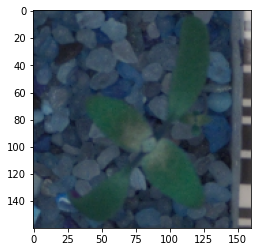

In [ ]:
plt.imshow(xtest[650])
print("Label: {}".format(np.argmax(predict[650])))

##Observation:

In [ ]:
*) Got the highest accuracy for CNN model with 88.6% validation whereas the Dense neural network model gives only 39.6%
   validation accuracy. Poor performing model is Random forest.

*) Reason CNN performs better is that, these model uses neighbourhood information of the images using filters unlike
   DNN model uses falttened data in which all the inputs are stacked in an array.
   
*) Filters helps the CNN to use less number of weights compared to other models.

*) Transfer learning in CNN helps the pre-trained model to use some known weights instead of random weights.

*) Image Augmentation is another key helps CNN to learn more pattern of images.

# AUTOMOBILE DATASET

In [76]:
details_df = pd.read_excel('/content/drive/MyDrive/Cars.xlsx')

In [77]:
details_df.head()

,ID,Name,Colour,Make,Type
0,1,TT,White,Audi,Sports
1,2,TL,Black,Acura,Sedan
2,3,Dodge Dakota,Red,Chrysler,Mid-size pick up truck
3,4,Sonata Hybrid,Red,Hyundai,Hybrid sedan
4,5,F series Super duty,White,Ford,Truck


In [78]:
details_df['ID']=details_df['ID'].map('{:0>5}'.format)

In [79]:
details_df['ID']=details_df['ID'].astype('str')

In [80]:
details_df.head()

,ID,Name,Colour,Make,Type
0,00001,TT,White,Audi,Sports
1,00002,TL,Black,Acura,Sedan
2,00003,Dodge Dakota,Red,Chrysler,Mid-size pick up truck
3,00004,Sonata Hybrid,Red,Hyundai,Hybrid sedan
4,00005,F series Super duty,White,Ford,Truck


In [81]:
details_df[details_df['ID']== '00002']

,ID,Name,Colour,Make,Type
1,00002,TL,Black,Acura,Sedan


In [8]:
 !unzip "/content/drive/MyDrive/Dataset - Images.zip"

Archive:  /content/drive/MyDrive/Dataset - Images.zip
  inflating: Images/00006.jpg        
  inflating: Images/00007.jpg        
  inflating: Images/00015.jpg        
  inflating: Images/00012.jpg        
  inflating: Images/00009.jpg        
  inflating: Images/00004.jpg        
  inflating: Images/00003.jpg        
  inflating: Images/00010.jpg        
  inflating: Images/00014.jpg        
  inflating: Images/00002.jpg        
  inflating: Images/00013.jpg        
  inflating: Images/00008.jpg        
  inflating: Images/00005.jpg        
  inflating: Images/00001.jpg        
  inflating: Images/00011.jpg        


In [9]:
os.chdir('/content/Images/')

In [114]:
images =[]
target=[]
img_r= 250

In [83]:
from tqdm import tqdm

In [56]:
details_df['ID'].values

array(['00001', '00002', '00003', '00004', '00005', '00006', '00007',
       '00008', '00009', '00010', '00011', '00012', '00013', '00014',
       '00015'], dtype=object)

In [120]:
for i in tqdm(details_df['ID'].values):
  pic = cv2.imread('/content/Images/{}.jpg'.format(i))
  RGB_img = cv2.cvtColor(pic, cv2.COLOR_BGR2RGB) ## changing the colour format 
  pic_res = cv2.resize(RGB_img,(300,300))
  images.append(pic_res)
  target.append(i)

100%|██████████| 15/15 [00:00<00:00, 110.97it/s]


In [121]:
X = np.array(images)

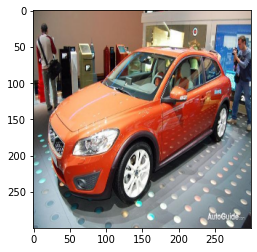

In [122]:
plt.imshow(X[14])

      ID Name Colour  Make    Type
0  00001   TT  White  Audi  Sports


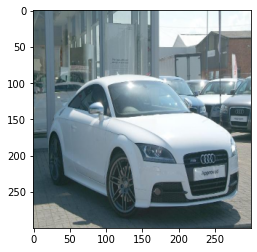

      ID Name Colour   Make   Type
1  00002   TL  Black  Acura  Sedan


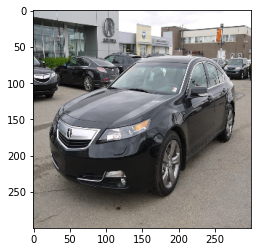

      ID          Name Colour      Make                    Type
2  00003  Dodge Dakota    Red  Chrysler  Mid-size pick up truck


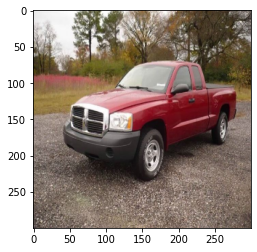

      ID           Name Colour     Make          Type
3  00004  Sonata Hybrid    Red  Hyundai  Hybrid sedan


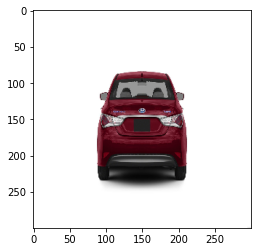

      ID                 Name Colour  Make   Type
4  00005  F series Super duty  White  Ford  Truck


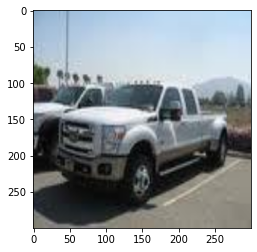

      ID       Name Colour            Make         Type
5  00006  Geo Metro    Red  General Motors  Convertible


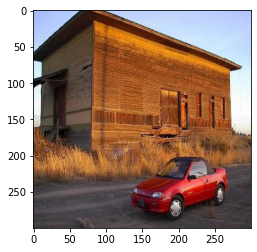

      ID           Name Colour      Make Type
6  00007  Dodge Journey   Blue  Chrysler  SUV


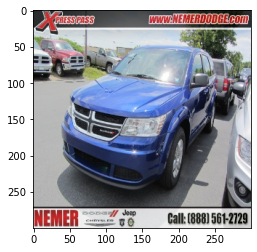

      ID           Name Colour      Make    Type
7  00008  Dodge Charger    Red  Chrysler  Muscle


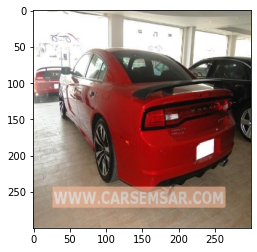

      ID    Name Colour        Make   Type
8  00009  Lancer   Grey  Mitsubishi  Sedan


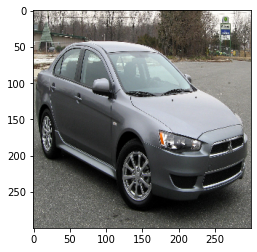

      ID      Name  Colour       Make           Type
9  00010  Traverse  Silver  Chevrolet  Crossover SUV


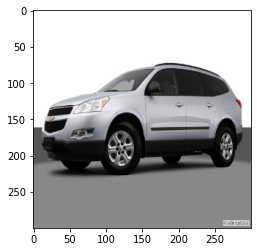

       ID    Name Colour  Make   Type
10  00011  Verano  White  Buic  Sedan


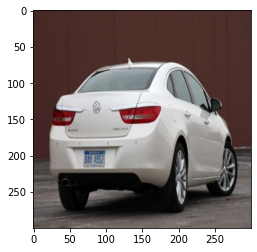

       ID     Name  Colour    Make Type
11  00012  Sequoia  Silver  Toyota  SUV


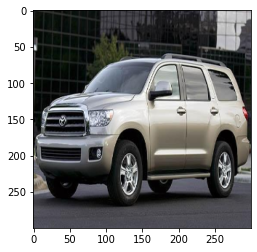

       ID     Name  Colour     Make   Type
12  00013  Elantra  Silver  Hyundai  Sedan


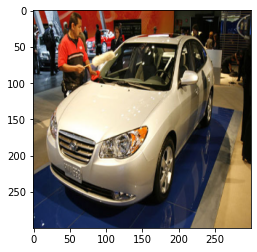

       ID                 Name Colour      Make Type
13  00014  Dodge Grand Caravan  White  Chrysler  SUV


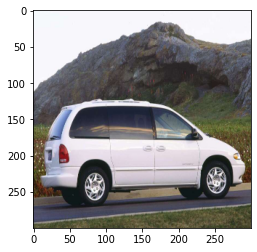

       ID Name  Colour   Make       Type
14  00015  C30  Orange  Volvo  Hatchback


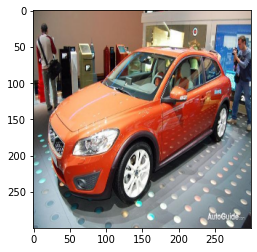

In [123]:
for i in range(0,15):
  plt.imshow(images[i])
  print(details_df[details_df['ID']== target[i]])
  plt.show()

In [70]:
Challenges Faced:
 
 *) Identifying what car is the first challenge. I used google lens for this purpose.
 *) While reading the image the color format was BGR and makes the car to look in different color. Changed the format.
 *) Displaying the image with its appropriate targets tooks time. However, managed to do it.

In [124]:
!jupyter nbconvert --to html AIML_R7_project2_Plant_and_Automobile.ipynb

[NbConvertApp] WARNING | pattern u'AIML_R7_project2_Plant_and_Automobile.ipynb' matched no files
This application is used to convert notebook files (*.ipynb) to various other
formats.


Options
-------

Arguments that take values are actually convenience aliases to full
Configurables, whose aliases are listed on the help line. For more information
on full configurables, see '--help-all'.

--execute
    Execute the notebook prior to export.
--allow-errors
    Continue notebook execution even if one of the cells throws an error and include the error message in the cell output (the default behaviour is to abort conversion). This flag is only relevant if '--execute' was specified, too.
--no-input
    Exclude input cells and output prompts from converted document. 
    This mode is ideal for generating code-free reports.
--stdout
    Write notebook output to stdout instead of files.
--stdin
    read a single notebook file from stdin. Write the resulting notebook with default basename 'noteb